## Data Import

In [1]:
import numpy as np
import pandas as pd 

import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, similarities
from gensim.models import LdaModel, CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud
import mpld3
from mpld3 import plugins, display
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.simplefilter('ignore')

In [2]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/charlottefeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlottefeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottefeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_excel('data/landscape_data.xlsx')

In [6]:
df

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M"
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T
5,South Jersey Robotics,Regional,1,Our Vision:\nTransform the culture in South Je...,SJR supports 18 FIRST Robotics teams consistin...,5.0,19.0,142027.0,No,E
6,Students 2 Science,Regional,1,"Students 2 Science, Inc. is a 501(c)(3) model ...",ISAAC engages middle and high school students ...,16.0,99.0,2515525.0,Yes,S
7,Bedtime Math,National,2,Our charitable mission is to help kids love nu...,We make math part of the family routine. Every...,3.0,9.0,2547614.0,NaN,M
8,Girls Scouts,National,2,Girl Scouts offers the best leadership develop...,Development of the Girl Scout Leadership Exper...,5.0,19.0,100106000.0,Yes,"S,T,E,M"
9,The Coder School,National,2,We are an after-school drop-off (and virtual) ...,Rather than using static one-size-fits-all cur...,7.0,18.0,169050.0,Yes,T


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   organization  22 non-null     object 
 1   type          13 non-null     object 
 2   priority      22 non-null     int64  
 3   mission       22 non-null     object 
 4   programs      13 non-null     object 
 5   min_age       12 non-null     float64
 6   max_age       12 non-null     float64
 7   revenue       11 non-null     float64
 8   charge        10 non-null     object 
 9   STEM_area     22 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 1.8+ KB


In [8]:
df.shape

(22, 10)

In [9]:
loc_df = pd.read_excel('data/landscape_data.xlsx', sheet_name='locations')

In [10]:
loc_df.head(5)

,organization,priority,address,latitude,longitude,state
0,JerseySTEM,0,"36 Chatham Rd, Summit, NJ 07901",40.732110,-74.377520,NJ
1,After School All Stars,1,"50 Park Pl #1020, Newark, NJ 07102",40.739090,-74.168530,NJ
2,FIRST Robotics Competition,1,"200 Bedford St, Manchester, NH 03101",42.989639,-71.467918,NH
3,Girls Who Code,1,"28 W 23rd St, Flatiron, New York, NY 10010",40.741890,-73.991420,NY
4,TechGirlz,1,"4230 Main Street, Philadelphia, PA 19127",40.024260,-75.221440,PA


### About data
- Two worksheets
    - Base
        - `mission` is scraped from organization websites in sections of "what we do"/"mission"/"vision".
        - `program` is scraped from GuideStar.
        - Though this is done manually, scrapers can be developed to automate the process.
        - For demonstration purpose, this analysis will be carried out on organizations with `priority != 3`
    - Locations
        - `organization` is not unique as one organization may have multiple sites

In [11]:
df = df[df['priority'] != 3]
loc_df = loc_df[loc_df['priority'] != 3]

In [12]:
# Reset index as some rows were skipped
df = df.reset_index(drop=True)
loc_df = loc_df.reset_index(drop=True)

In [13]:
df.shape[0]

13

### Feature Engineering for Organization Interest

In [14]:
def get_age_group(min_age, max_age):
    def is_overlap(a, b):
        """
        Determines whether two intervals overlap
        """
        overlap = max(0, min(a[1], b[1]) - max(a[0], b[0]))
        return True if overlap != 0 else False
    # Missing data
    if np.isnan(min_age) and np.isnan(max_age): 
        return np.nan
    
    age = [min_age, max_age]
    age_group = []
    
    if is_overlap([0, 4], age):
        age_group.append('preschool')
    if is_overlap([5, 19], age):
        age_group.append('K-12')
    if is_overlap([20, 25], age):
        age_group.append('young adults')
    if is_overlap([26, 99], age):
        age_group.append('adults')
                
    return ','.join(age_group)

In [15]:
df['age_group'] = df.apply(lambda x: get_age_group(x.min_age, x.max_age),
                           axis=1)

In [16]:
df

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12
5,South Jersey Robotics,Regional,1,Our Vision:\nTransform the culture in South Je...,SJR supports 18 FIRST Robotics teams consistin...,5.0,19.0,142027.0,No,E,K-12
6,Students 2 Science,Regional,1,"Students 2 Science, Inc. is a 501(c)(3) model ...",ISAAC engages middle and high school students ...,16.0,99.0,2515525.0,Yes,S,"K-12,young adults,adults"
7,Bedtime Math,National,2,Our charitable mission is to help kids love nu...,We make math part of the family routine. Every...,3.0,9.0,2547614.0,NaN,M,"preschool,K-12"
8,Girls Scouts,National,2,Girl Scouts offers the best leadership develop...,Development of the Girl Scout Leadership Exper...,5.0,19.0,100106000.0,Yes,"S,T,E,M",K-12
9,The Coder School,National,2,We are an after-school drop-off (and virtual) ...,Rather than using static one-size-fits-all cur...,7.0,18.0,169050.0,Yes,T,K-12


## Preprocessing & EDA

### Text Cleaning
- Lowercase
- Remove punctuations, special characters and digits
- Tokenization
- Lemmatization
- Remove stopwords. Also exclude 
    - Organization names (and their acronyms)
    - Some other frequent words we are not interested in, i.e., words that are likely to appear for almost every document
    - *Remark: we don't want the repetitive occurences of these words to affect token frequency later.*
        -  ['nonprofit','non','profit','inc','program','mission', 'organization','world','today','day','jersey','student','kid','education','year','age']
- Vectorization: TF-IDF

#### Helper Functions

In [17]:
def lemma_tokenizer(text, min_char=3):
    """
    Performs tokenization and lemmatization.
    @min_char: minimum character of a token
    """
    lemmer = WordNetLemmatizer()
    return [lemmer.lemmatize(t) for t in word_tokenize(text)\
            if (len(t) >= min_char)]

In [18]:
def get_acronyms(str_list):
    """
    Gets the acronyms of a list of strings
    """
    acronyms = []
    for s in str_list:
        s_ls = s.split(' ')
        if len(s_ls) > 1:
            acrn = ''.join([w[0] for w in s_ls])
            acronyms.append(acrn)
    return acronyms

In [19]:
def stopwords_remover(tokens, stop_words):
    """
    Removes stopwords in a list of tokens
    """
    return [word for word in tokens if not word in stop_words]

In [20]:
def preprocessor(text):
    """
    Transforms text into lowercase.
    Removes punctuations, special characters and digits.
    """
    return re.sub(r'[^A-Za-z]+', ' ', text.lower())

In [21]:
def preprocess(df, target, vectorize=True):
    """
    Preprocesses text columns.
    1. Lowercase
    2. Remove punctuations, special characters and digits
    3. Tokenize
    4. Lemmatize
    5. Remove stopwords
    6. Vectorize
    @target: target column to preprocess
    @vectorize: whether or not to vectorize the tokens
    """
    # Create a list of stopwords to remove
    stop_words = stopwords.words('english')
    to_exclude = ['nonprofit','non','profit','inc','program',\
                  'mission', 'organization','world','today','day',\
                  'jersey','school','student','kid','education'\
                  'year', 'age']
    org = df.organization.tolist()
    org_acrn = get_acronyms(org)
    to_exclude.extend(org)
    to_exclude.extend(org_acrn)
    stop_words.extend(to_exclude)
    stop_words = [w.lower() for w in stop_words]
    print(f'Stopwords removed:\n{stop_words}')
    
    # Preprocess: 1-5
    new_c = '_'.join([target, 'cleaned'])
    df[new_c] = df[target].apply(preprocessor)
    df[new_c] = df[new_c].apply(lemma_tokenizer)
    df[new_c] = df[new_c].apply(stopwords_remover, stop_words=stop_words)
    
    # Vectorize
    if vectorize:
        tfidf = TfidfVectorizer(
            preprocessor=preprocessor,
            tokenizer=lemma_tokenizer,
            stop_words=stop_words,
            min_df=2) # ngram_range=(1, 3)
        tfidf_matrix = tfidf.fit_transform(df[target])
        
        return df, tfidf, tfidf_matrix

    return df

In [22]:
df_cleaned, mis_tfidf, mis_mat = preprocess(df, 'mission')

Stopwords removed:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

In [23]:
df_cleaned[['mission', 'mission_cleaned']].head(5)

,mission,mission_cleaned
0,JerseySTEM is a non-profit organization that p...,"[promotes, excellence, science, technology, en..."
1,"After-School All-Stars provides free, comprehe...","[star, provides, free, comprehensive, keep, ch..."
2,"FIRST LEGO League introduces science, technolo...","[first, lego, league, introduces, science, tec..."
3,Girls Who Code is on a mission to close the ge...,"[girl, code, close, gender, gap, technology, c..."
4,TechGirlz is a nonprofit program of Creating I...,"[creating, future, comptia, inspires, middle, ..."


### WordCloud

In [24]:
def plot_wordcloud(text, title):
    """
    Plots the wordcloud for a given text dataframe/array/list
    @title: plot title
    """
    # Concatenate into a single string
    text_str = ''.join(str(t) for t in text) 
    
    # Remove some unwanted words by POS
    # pos to keep: adj, adv, n(p)
    pos = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', \
           'NNP', 'NNPS', 'PDT', 'POS',\
           'RB', 'RBR', 'RBS'] 
    tokens = word_tokenize(text_str)
    tokens_tag = pos_tag(tokens)
    tokens_filtered = [t[0] for t in tokens_tag if t[1] in pos]
    text_filtered = ' '.join(str(t) for t in tokens_filtered)
    
    wordcloud = WordCloud(max_words=100,
                          max_font_size=100, width=1000, height=500,
                          background_color='white').generate(text_filtered)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for {title}', fontsize=15)
    plt.savefig(f'img/wc_{title}.png', dpi=200)
    plt.show()

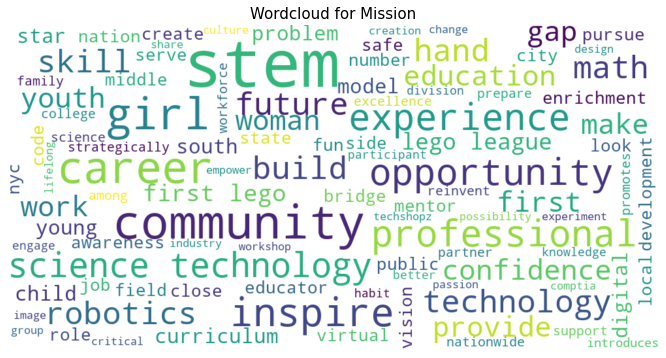

In [25]:
plot_wordcloud(df_cleaned.mission_cleaned, 'Mission')

## Similarity Analysis for Missions

In [26]:
mis_vocab = mis_tfidf.get_feature_names()

In [27]:
mis_mat.shape

(13, 78)

In [28]:
mis_dist = 1 - cosine_similarity(mis_mat)

In [29]:
mis_dist.shape

(13, 13)

### K-means Clustering
- Given the small dataset, tuning is not so necessary as larger K will always lead to smaller inertia.

In [30]:
SEED = 42

In [31]:
def fit_kmeans(text_matrix, K=3, tuning=False):
    if tuning:
        K = range(2, 6)
        inertia = [] # Sum of squared distances of samples to their closest cluster center
        for k in K:
            km = KMeans(n_clusters=k,
                        random_state=SEED)
            km = km.fit(text_matrix)
            inertia.append(km.inertia_)
            
        # Elbow method
        plt.plot(K, inertia, 'bx-')
        plt.xlabel('K')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.show()
    else:
        km = KMeans(n_clusters=K, random_state=SEED)
        km.fit(text_matrix)
        clusters = km.labels_.tolist()

        return km, clusters

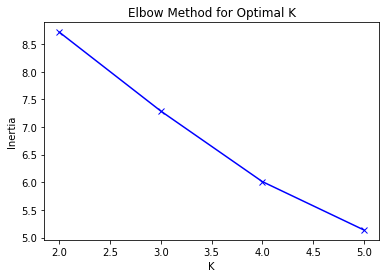

In [32]:
fit_kmeans(mis_mat, tuning=True)

In [33]:
km, clusters = fit_kmeans(mis_mat, K=5)

In [34]:
df_cleaned['cluster'] = clusters

In [35]:
df_cleaned['cluster'].value_counts()

0    5
2    3
3    2
1    2
4    1
Name: cluster, dtype: int64

In [36]:
def get_cluster_top_words(km, K, n=5, vocab=mis_vocab):
    # Sort words by proximity to cluster centroid
    words_ordered = km.cluster_centers_.argsort()[:,::-1] # Word index
    cluster_words = {}
    
    results = pd.DataFrame(columns=['cluster', 'words'])
    for i in range(K):
        top_n = km.cluster_centers_.argsort()[:,::-1][i,:n]
        top_n_words = ', '.join([vocab[i] for i in top_n]) # String
        cluster_words[i] = top_n_words 
    
    return cluster_words

In [37]:
cluster_words = get_cluster_top_words(km, 5)

In [38]:
cluster_words

{0: 'stem, education, professional, career, community',
 1: 'first, robotics, hand, learning, skill',
 2: 'help, life, close, look, like',
 3: 'girl, development, leadership, free, offer',
 4: 'learning, virtual, coding, code, youth'}

In [39]:
df_cleaned['cluster_keywords'] = df_cleaned['cluster'].map(cluster_words)

In [40]:
df_cleaned.head(5)

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group,mission_cleaned,cluster,cluster_keywords
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN,"[promotes, excellence, science, technology, en...",0,"stem, education, professional, career, community"
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12,"[star, provides, free, comprehensive, keep, ch...",2,"help, life, close, look, like"
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12,"[first, lego, league, introduces, science, tec...",1,"first, robotics, hand, learning, skill"
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12,"[girl, code, close, gender, gap, technology, c...",2,"help, life, close, look, like"
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12,"[creating, future, comptia, inspires, middle, ...",3,"girl, development, leadership, free, offer"


**Which organizations are in the same cluster as JerseySTEM?**

In [41]:
js_cluster = int(
    df_cleaned.loc[df_cleaned['organization'] == 'JerseySTEM', 'cluster'])

In [42]:
df_cleaned.loc[df_cleaned['cluster'] == js_cluster,\
               ['organization', 'mission', 'cluster_keywords']]

,organization,mission,cluster_keywords
0,JerseySTEM,JerseySTEM is a non-profit organization that p...,"stem, education, professional, career, community"
6,Students 2 Science,"Students 2 Science, Inc. is a 501(c)(3) model ...","stem, education, professional, career, community"
10,STEM Kids NYC,STEM Kids NYC is a 501(c)(3) organization that...,"stem, education, professional, career, community"
11,Stem Alliance of Larchmont-Mamaroneck Inc,"The STEM Alliance is a grass-roots, 501(c)(3) ...","stem, education, professional, career, community"
12,Digital Girl,"Digital Girl, Incorporated was founded in 2014...","stem, education, professional, career, community"


### Visualization: Multidimensional scaling

In [43]:
def plot_cluster(df=df_cleaned, dist=mis_dist, 
                 interactive=False):
    """
    @dist: distance matrix
    @interactive: whether or not to use mpld3 for plotting.
     Defaulted to False as for small datasets this is not helpful.
    """
    # Map dist to 2D-array (i.e., coordinates)
    mds = MDS(dissimilarity='precomputed', 
          random_state=SEED)
    coord = mds.fit_transform(dist)
    plot_df = df.copy(deep=True) # Make a copy to plot
    plot_df['_x'], plot_df['_y'] = coord[:, 0], coord[:, 1]
    
    # Create a colormap for each cluster
    n_clusters = plot_df.cluster.nunique()
    cmap = cm.get_cmap('Paired', n_clusters)
    plot_df['color'] = plot_df['cluster'].map(cmap)

    fig, ax = plt.subplots(figsize=(16, 10))
    for i in range(len(df)):
        x = plot_df.loc[plot_df.index[i], '_x']
        y = plot_df.loc[plot_df.index[i], '_y']
        lab = plot_df.loc[plot_df.index[i], 'cluster_keywords']
        clr = plot_df.loc[plot_df.index[i], 'color']
        org = plot_df.loc[plot_df.index[i], 'organization']
        padding = 0.02
        
        points = ax.plot(x, y, label=lab, color=clr,
                         marker='o', linestyle='', ms=15, mec='none')
        
        # Annotate the organizations
        if interactive:
            # Plot using mpld3. Useful for higher dimensions.
            tooltip = plugins.PointLabelTooltip(points[0], [org])
            plugins.connect(fig, tooltip)
        else:
            size = 15 if org == 'JerseySTEM' else 10
            color = 'red' if org == 'JerseySTEM' else 'black'
            ax.text(x+padding, y, org, size=size, color=color)  
    
    ax.legend()
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys(), loc='lower left')
    
    ax.set_aspect('auto')
    plt.axis('off')
    plt.tight_layout()
    if interactive:
        mpld3.show()
    else:
        plt.savefig('img/cluster.png', dpi=200)
        plt.show()
    
    return pd.concat([df, plot_df[['_x', '_y']]], axis=1)

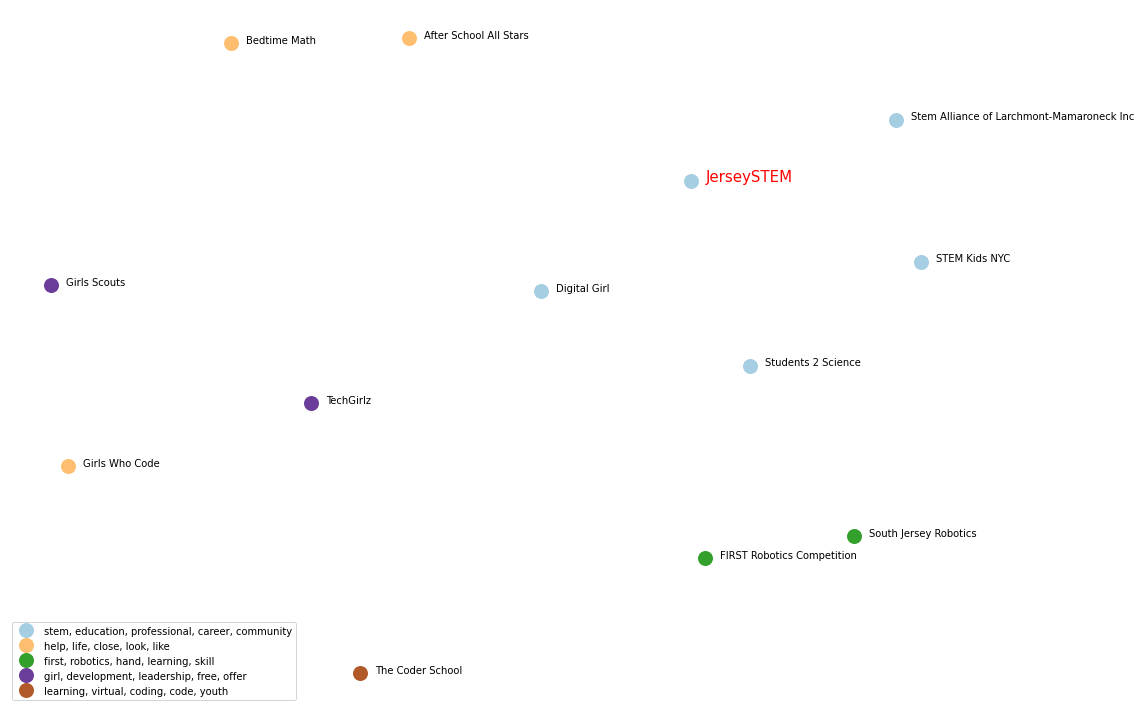

In [44]:
df_cleaned = plot_cluster()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [15/Sep/2020 11:47:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:15] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:15] "GET /mpld3.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:15] code 404, message Not Found
127.0.0.1 - - [15/Sep/2020 11:47:15] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 -
127.0.0.1 - - [15/Sep/2020 11:47:15] code 404, message Not Found
127.0.0.1 - - [15/Sep/2020 11:47:15] "GET /apple-touch-icon.png HTTP/1.1" 404 -



stopping Server...


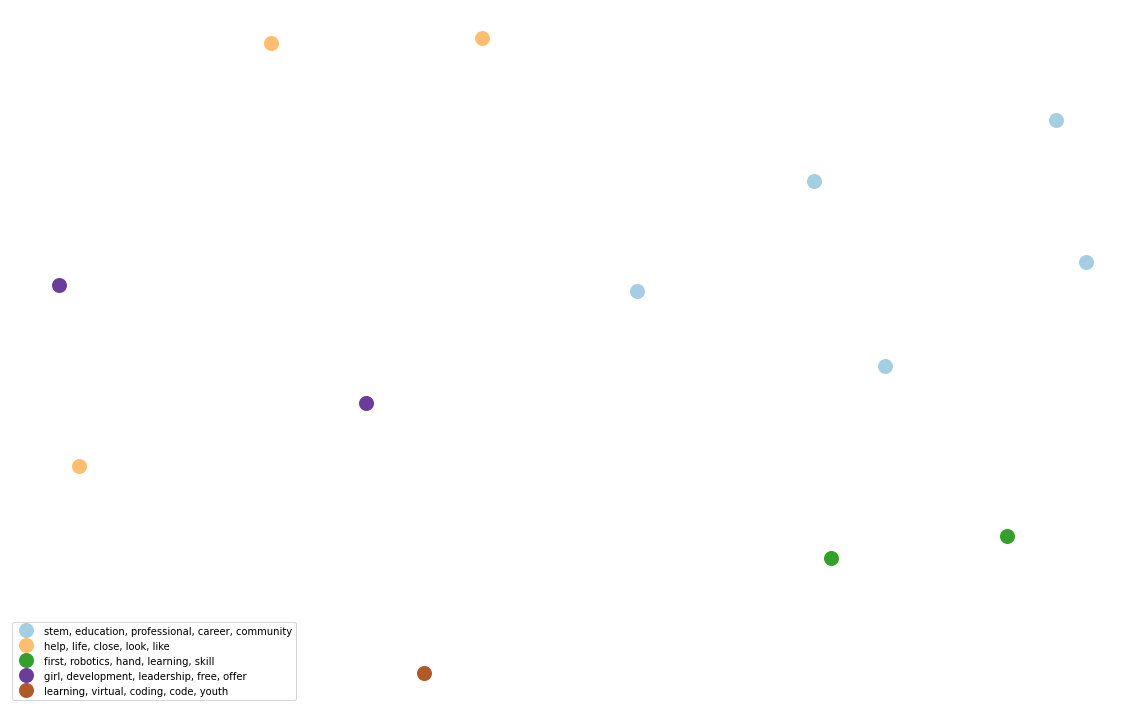

In [45]:
_ = plot_cluster(interactive=True)

**Remarks:**
- Organizations with the same color are of the same cluster so that they share similar missions.
- The distance between each organization shows the difference in missions.
    - Closer organizations are more similar in missions (also higher probability of collaboration/competition?)
- What's more?
    - Topic modeling using LDA
        - To draw insights on content design (workshops, programs)

## Topic Modeling for Programs (with Gensim)

In [46]:
df_cleaned = preprocess(df_cleaned, 'programs', False)

Stopwords removed:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

In [47]:
df_cleaned.head(5)

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group,mission_cleaned,cluster,cluster_keywords,_x,_y,programs_cleaned
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN,"[promotes, excellence, science, technology, en...",0,"stem, education, professional, career, community",0.223777,0.298778,"[mystemclub, learn, teamwork, problem, solving..."
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12,"[star, provides, free, comprehensive, keep, ch...",2,"help, life, close, look, like",-0.149756,0.595951,"[ready, prepares, risk, grader, success, high,..."
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12,"[first, lego, league, introduces, science, tec...",1,"first, robotics, hand, learning, skill",0.242453,-0.484787,"[first, lego, league, engages, yr, fun, combin..."
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12,"[girl, code, close, gender, gap, technology, c...",2,"help, life, close, look, like",-0.602952,-0.294468,"[club, grade, girl, explore, coding, fun, frie..."
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12,"[creating, future, comptia, inspires, middle, ...",3,"girl, development, leadership, free, offer",-0.280902,-0.163063,"[techshopz, free, hand, technology, workshop, ..."


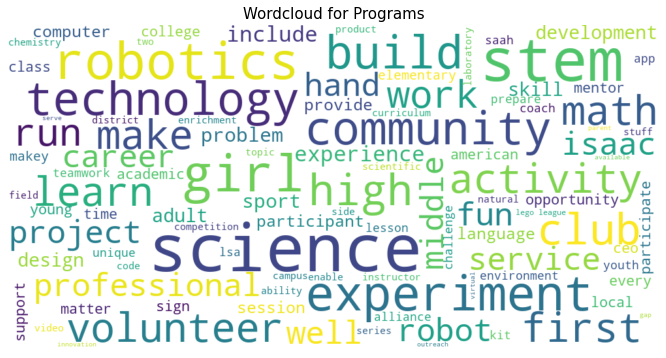

In [48]:
plot_wordcloud(df_cleaned.programs_cleaned, 'Programs')

In [49]:
programs_text = df_cleaned.programs_cleaned
# Create dictionary
programs_dict = corpora.Dictionary(programs_text)
# Filter out extremes
programs_dict.filter_extremes(no_below=2, no_above=0.8)
# Get term frequency
programs_corpus = [programs_dict.doc2bow(t) for t in programs_text]

In [50]:
# Sample corpus
[(programs_dict[i], j) for i, j in programs_corpus[0]]

[('app', 2),
 ('area', 1),
 ('available', 1),
 ('build', 1),
 ('club', 5),
 ('coding', 1),
 ('college', 1),
 ('community', 1),
 ('course', 1),
 ('create', 1),
 ('environment', 1),
 ('grade', 1),
 ('innovation', 1),
 ('learn', 2),
 ('offered', 1),
 ('opportunity', 1),
 ('parent', 1),
 ('problem', 1),
 ('run', 1),
 ('serve', 1),
 ('stem', 1),
 ('teamwork', 1),
 ('virtual', 1),
 ('volunteer', 1),
 ('work', 1)]

*Remark on removal of extremes:*

We filter out words with large frequencies as well as we want the topics to be specific and non-overlapping

### Model

In [51]:
lda = LdaModel(
    corpus=programs_corpus,
    id2word=programs_dict,
    num_topics=3, 
    random_state=SEED,
    update_every=1, 
    passes=100, # training passes
    alpha='auto',
    chunksize=500 # num of documents in one pass
) 

In [52]:
topics = lda.show_topics()
for t in topics:
    print(f'Topic {t[0]} =\n{t[1]}\n')

Topic 0 =
0.046*"girl" + 0.038*"club" + 0.026*"make" + 0.026*"service" + 0.026*"community" + 0.022*"learn" + 0.022*"coding" + 0.018*"high" + 0.018*"career" + 0.018*"learning"

Topic 1 =
0.041*"science" + 0.032*"team" + 0.029*"experiment" + 0.023*"first" + 0.020*"teacher" + 0.020*"well" + 0.016*"grade" + 0.016*"build" + 0.016*"technology" + 0.016*"volunteer"

Topic 2 =
0.041*"stem" + 0.032*"summer" + 0.032*"robotics" + 0.028*"learning" + 0.028*"programming" + 0.028*"engineering" + 0.028*"science" + 0.023*"participant" + 0.023*"activity" + 0.019*"week"



- Weight implies importance of the word to the topic
- Ideally, we want each topic to be distinct - to have distinct keywords.

### Evaluation

In [53]:
# Aim for lower perplexity
print('Perplexity: ', lda.log_perplexity(programs_corpus))

Perplexity:  -5.050835970435636


In [54]:
coherence = CoherenceModel(model=lda, 
                           texts=programs_text, 
                           dictionary=programs_dict, 
                           coherence='c_v')
coherence_lda = coherence.get_coherence()

print('Baseline coherence: ', coherence_lda)

Baseline coherence:  0.38025332912182014


- Topic Coherence measures relative distance between words within a topic.
- For `C_V`, 0 < coherence < 1. Higher similarity -> Higher coherence.

### Tuning K: the optimal number of topics

In [55]:
def compute_coherence(dictionary=programs_dict, 
                      corpus=programs_corpus, 
                      texts=programs_text, 
                      start=2, end=7, step=1):
    """
    Computes coherence for the LDA models
    given a search space for num_topics defined by (start, end, step).
    Since we only have 13 corpus, we will set end to be 7 
    so that at most 6 topics should be formed for the organization's programs
    """
    coherence = []
    model_list = []
    
    for n_topics in range(start, end, step):
        lda = LdaModel(
            corpus,
            id2word=dictionary,
            num_topics=n_topics, 
            random_state=SEED,
            update_every=1, 
            passes=100,
            alpha='auto',
            chunksize=500)
        
        model_list.append(lda)
        coherence_lda = CoherenceModel(model=lda, 
                                       texts=texts, 
                                       dictionary=dictionary, 
                                       coherence='c_v')
        coherence.append(coherence_lda.get_coherence())
    
    
    x = range(start, end, step)
    plt.plot(x, coherence)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.title('Choosing Optimal Number of Topics Based on Coherence')
    plt.show()
    
    # Summarize results
    best_k = x[np.argmax(coherence)]
    print(f'Best Number of Topics: {best_k}')
    print(f'Best coherence: {np.max(coherence)}')
    
    return model_list[np.argmax(coherence)]

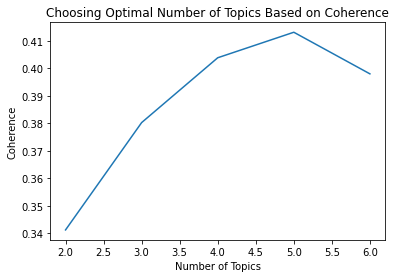

Best Number of Topics: 5
Best coherence: 0.41306901109596217


In [56]:
best_lda = compute_coherence()

In [57]:
topics = best_lda.show_topics()
for t in topics:
    print(f'Topic {t[0]} =\n{t[1]}\n')

Topic 0 =
0.090*"girl" + 0.032*"provide" + 0.032*"team" + 0.032*"learning" + 0.017*"consistently" + 0.017*"support" + 0.017*"design" + 0.017*"led" + 0.017*"experience" + 0.017*"adult"

Topic 1 =
0.056*"science" + 0.046*"experiment" + 0.029*"grade" + 0.026*"girl" + 0.026*"teacher" + 0.025*"volunteer" + 0.021*"well" + 0.021*"session" + 0.021*"middle" + 0.021*"coding"

Topic 2 =
0.042*"stem" + 0.033*"learning" + 0.033*"robotics" + 0.029*"programming" + 0.029*"science" + 0.029*"engineering" + 0.029*"summer" + 0.024*"activity" + 0.019*"run" + 0.019*"week"

Topic 3 =
0.042*"team" + 0.040*"club" + 0.032*"first" + 0.032*"build" + 0.027*"make" + 0.026*"work" + 0.022*"fun" + 0.022*"year" + 0.022*"lego" + 0.022*"robot"

Topic 4 =
0.069*"high" + 0.053*"career" + 0.044*"service" + 0.036*"community" + 0.036*"participate" + 0.027*"sport" + 0.027*"academic" + 0.027*"learning" + 0.027*"development" + 0.027*"opportunity"



### Visualization

In [58]:
vis = pyLDAvis.gensim.prepare(best_lda, programs_corpus, programs_dict)

In [59]:
pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [15/Sep/2020 11:47:43] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:43] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [15/Sep/2020 11:47:44] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


- The larger the bubble, the more prevalent is that topic.
- Ideally, we want to have large, non-overlapping bubbles.
- For each topic, salient words are shown.

### Finding the dominant topic for each organization

In [60]:
def get_dominant_topic(model=best_lda,
                       corpus=programs_corpus, 
                       texts=programs_text,
                       df=df_cleaned):
    """
    Finds the dominant topic for each corpus (organization)
    """
    # Initiate a dataframe for results
    columns = ['dominant_topic', 'topic_prop', 'topic_keywords']
    results = pd.DataFrame(columns=columns)
    
    # Get the dominant topic
    for i in range(len(corpus)):
        # topics: [(topic, proportion), ...] for corpus i (i-th organization)
        topics = model[corpus[i]]
        # Sort by topic proportion
        top_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
        # vocabs: [(vocab, weight), ...]
        topic_idx, topic_prop = top_topic[0], top_topic[1]
        vocabs = model.show_topic(topic_idx)
        # Sort by vocabulary proportion
        vocabs = sorted(vocabs, key=lambda x: (x[1]), reverse=True)
        vocabs_list = ', '.join([v for v, _ in vocabs])
        
        res = pd.DataFrame([[topic_idx, topic_prop, vocabs_list]], 
                           columns=columns)
        
        results = pd.concat([results, res]).reset_index(drop=True)
    
    # Stack vertically to the cleaned dataset
    # For integrity, replace duplicates
    if columns in df.columns.tolist(): 
        df = df.drop(columns, axis=1)
    df = pd.concat([df, results], axis=1, verify_integrity=True)
    return df

In [61]:
df_cleaned = get_dominant_topic()

In [62]:
df_cleaned

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group,mission_cleaned,cluster,cluster_keywords,_x,_y,programs_cleaned,dominant_topic,topic_prop,topic_keywords
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN,"[promotes, excellence, science, technology, en...",0,"stem, education, professional, career, community",0.223777,0.298778,"[mystemclub, learn, teamwork, problem, solving...",3,0.619118,"team, club, first, build, make, work, fun, yea..."
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12,"[star, provides, free, comprehensive, keep, ch...",2,"help, life, close, look, like",-0.149756,0.595951,"[ready, prepares, risk, grader, success, high,...",4,0.998648,"high, career, service, community, participate,..."
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12,"[first, lego, league, introduces, science, tec...",1,"first, robotics, hand, learning, skill",0.242453,-0.484787,"[first, lego, league, engages, yr, fun, combin...",3,0.999249,"team, club, first, build, make, work, fun, yea..."
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12,"[girl, code, close, gender, gap, technology, c...",2,"help, life, close, look, like",-0.602952,-0.294468,"[club, grade, girl, explore, coding, fun, frie...",1,0.997518,"science, experiment, grade, girl, teacher, vol..."
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12,"[creating, future, comptia, inspires, middle, ...",3,"girl, development, leadership, free, offer",-0.280902,-0.163063,"[techshopz, free, hand, technology, workshop, ...",0,0.992558,"girl, provide, team, learning, consistently, s..."
5,South Jersey Robotics,Regional,1,Our Vision:\nTransform the culture in South Je...,SJR supports 18 FIRST Robotics teams consistin...,5.0,19.0,142027.0,No,E,K-12,"[vision, transform, culture, south, surroundin...",1,"first, robotics, hand, learning, skill",0.441159,-0.438757,"[support, first, robotics, team, consisting, t...",0,0.988366,"girl, provide, team, learning, consistently, s..."
6,Students 2 Science,Regional,1,"Students 2 Science, Inc. is a 501(c)(3) model ...",ISAAC engages middle and high school students ...,16.0,99.0,2515525.0,Yes,S,"K-12,young adults,adults","[science, model, new, bridge, need, public, pr...",0,"stem, education, professional, career, community",0.303311,-0.084887,"[isaac, engages, middle, high, real, problem, ...",1,0.845808,"science, experiment, grade, girl, teacher, vol..."
7,Bedtime Math,National,2,Our charitable mission is to help kids love nu...,We make math part of the family routine. Every...,3.0,9.0,2547614.0,NaN,M,"preschool,K-12","[charitable, help, love, number, handle, math,...",2,"help, life, close, look, like",-0.386901,0.585861,"[make, math, part, family, routine, every, ser...",3,0.997772,"team, club, first, build, make, work, fun, yea..."
8,Girls Scouts,National,2,Girl Scouts offers the best leadership develop...,Development of the Girl Scout Leadership Exper...,5.0,19.0,100106000.0,Yes,"S,T,E,M",K-12,"[girl, scout, offer, best, leadership, develop...",3,"girl, development, leadership, free, offer",-0.626246,0.081979,"[development, girl, scout, leadership, experie...",0,0.996084,"girl, provide, team, learning, consistently, s..."
9,The Coder School,National,2,We are an after-school drop-off (and virtual) ...,Rather than using static one-size-fits-all cur...,7.0,18.0,169050.0,Yes,T,K-12,"[drop, virtual, learning, code, coding]",4,"learning, virtual, coding, code, youth",-

In [63]:
df_cleaned.head(5)

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group,mission_cleaned,cluster,cluster_keywords,_x,_y,programs_cleaned,dominant_topic,topic_prop,topic_keywords
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN,"[promotes, excellence, science, technology, en...",0,"stem, education, professional, career, community",0.223777,0.298778,"[mystemclub, learn, teamwork, problem, solving...",3,0.619118,"team, club, first, build, make, work, fun, yea..."
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12,"[star, provides, free, comprehensive, keep, ch...",2,"help, life, close, look, like",-0.149756,0.595951,"[ready, prepares, risk, grader, success, high,...",4,0.998648,"high, career, service, community, participate,..."
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12,"[first, lego, league, introduces, science, tec...",1,"first, robotics, hand, learning, skill",0.242453,-0.484787,"[first, lego, league, engages, yr, fun, combin...",3,0.999249,"team, club, first, build, make, work, fun, yea..."
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12,"[girl, code, close, gender, gap, technology, c...",2,"help, life, close, look, like",-0.602952,-0.294468,"[club, grade, girl, explore, coding, fun, frie...",1,0.997518,"science, experiment, grade, girl, teacher, vol..."
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12,"[creating, future, comptia, inspires, middle, ...",3,"girl, development, leadership, free, offer",-0.280902,-0.163063,"[techshopz, free, hand, technology, workshop, ...",0,0.992558,"girl, provide, team, learning, consistently, s..."


**Which organizations share the same dominant topic as JerseySTEM?**

In [64]:
js_topic = int(
    df_cleaned.loc[df_cleaned['organization'] == 'JerseySTEM', 
                   'dominant_topic'])

In [65]:
cols_of_interest = ['organization','cluster_keywords','topic_keywords']

In [66]:
df_cleaned[df_cleaned['dominant_topic'] == js_topic]\
[cols_of_interest]

,organization,cluster_keywords,topic_keywords
0,JerseySTEM,"stem, education, professional, career, community","team, club, first, build, make, work, fun, yea..."
2,FIRST Robotics Competition,"first, robotics, hand, learning, skill","team, club, first, build, make, work, fun, yea..."
7,Bedtime Math,"help, life, close, look, like","team, club, first, build, make, work, fun, yea..."
12,Digital Girl,"stem, education, professional, career, community","team, club, first, build, make, work, fun, yea..."


### Finding the most representative organization for each topic

In [67]:
df_cleaned[['organization','programs', \
            'dominant_topic', 'topic_prop', 'topic_keywords']]\
    .sort_values('topic_prop', ascending=False)\
    .groupby(['dominant_topic', 'topic_keywords']).head(1)

,organization,programs,dominant_topic,topic_prop,topic_keywords
10,STEM Kids NYC,"Our hands-on, student centered afterschool pro...",2,0.999275,"stem, learning, robotics, programming, science..."
2,FIRST Robotics Competition,FIRST LEGO League is a program that engages st...,3,0.999249,"team, club, first, build, make, work, fun, yea..."
1,After School All Stars,We Are Ready (W.A.R.) prepares at-risk 8th gra...,4,0.998648,"high, career, service, community, participate,..."
3,Girls Who Code,After-school clubs for 3rd–12th grade girls to...,1,0.997518,"science, experiment, grade, girl, teacher, vol..."
8,Girls Scouts,Development of the Girl Scout Leadership Exper...,0,0.996084,"girl, provide, team, learning, consistently, s..."


## Closing notes
### Does the organizations with similar mission statements as JerseySTEM also have similar programs?

In [68]:
df_cleaned[(df_cleaned['cluster'] == js_cluster) |\
          (df_cleaned['dominant_topic'] == js_topic)]\
[cols_of_interest]

,organization,cluster_keywords,topic_keywords
0,JerseySTEM,"stem, education, professional, career, community","team, club, first, build, make, work, fun, yea..."
2,FIRST Robotics Competition,"first, robotics, hand, learning, skill","team, club, first, build, make, work, fun, yea..."
6,Students 2 Science,"stem, education, professional, career, community","science, experiment, grade, girl, teacher, vol..."
7,Bedtime Math,"help, life, close, look, like","team, club, first, build, make, work, fun, yea..."
10,STEM Kids NYC,"stem, education, professional, career, community","stem, learning, robotics, programming, science..."
11,Stem Alliance of Larchmont-Mamaroneck Inc,"stem, education, professional, career, community","stem, learning, robotics, programming, science..."
12,Digital Girl,"stem, education, professional, career, community","team, club, first, build, make, work, fun, yea..."


In [69]:
df_cleaned[(df_cleaned['cluster'] == js_cluster) &\
          (df_cleaned['dominant_topic'] == js_topic)]\
['organization']

0       JerseySTEM
12    Digital Girl
Name: organization, dtype: object

- Only Digital Girl has both a similar mission and a similar program design.
- It also seems to be closest point to JerseySTEM in terms of cluster assignment.

In [70]:
with pd.option_context('display.max_colwidth', -1):
    print(
        df_cleaned.loc[df_cleaned['organization']\
                       .isin(['JerseySTEM', 'Digital Girl']),\
                       ['organization', 'mission', 'programs']]
    )

    organization  \
0   JerseySTEM     
12  Digital Girl   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      mission  \
0   JerseySTEM is a non-profit organizatio

In [71]:
df_cleaned

,organization,type,priority,mission,programs,min_age,max_age,revenue,charge,STEM_area,age_group,mission_cleaned,cluster,cluster_keywords,_x,_y,programs_cleaned,dominant_topic,topic_prop,topic_keywords
0,JerseySTEM,Local,0,JerseySTEM is a non-profit organization that p...,"MySTEMClub\nLearn Teamwork, Problem Solving, a...",NaN,NaN,NaN,Yes,"S,T,E,M",NaN,"[promotes, excellence, science, technology, en...",0,"stem, education, professional, career, community",0.223777,0.298778,"[mystemclub, learn, teamwork, problem, solving...",3,0.619118,"team, club, first, build, make, work, fun, yea..."
1,After School All Stars,National,1,"After-School All-Stars provides free, comprehe...",We Are Ready (W.A.R.) prepares at-risk 8th gra...,5.0,19.0,11897154.0,NaN,S,K-12,"[star, provides, free, comprehensive, keep, ch...",2,"help, life, close, look, like",-0.149756,0.595951,"[ready, prepares, risk, grader, success, high,...",4,0.998648,"high, career, service, community, participate,..."
2,FIRST Robotics Competition,National,1,"FIRST LEGO League introduces science, technolo...",FIRST LEGO League is a program that engages st...,5.0,19.0,1880324.0,Yes,E,K-12,"[first, lego, league, introduces, science, tec...",1,"first, robotics, hand, learning, skill",0.242453,-0.484787,"[first, lego, league, engages, yr, fun, combin...",3,0.999249,"team, club, first, build, make, work, fun, yea..."
3,Girls Who Code,National,1,Girls Who Code is on a mission to close the ge...,After-school clubs for 3rd–12th grade girls to...,5.0,20.0,19459149.0,Yes,T,K-12,"[girl, code, close, gender, gap, technology, c...",2,"help, life, close, look, like",-0.602952,-0.294468,"[club, grade, girl, explore, coding, fun, frie...",1,0.997518,"science, experiment, grade, girl, teacher, vol..."
4,TechGirlz,National,1,TechGirlz is a nonprofit program of Creating I...,"TechShopz are free, hands-on technology worksh...",13.0,19.0,251774.0,Yes,T,K-12,"[creating, future, comptia, inspires, middle, ...",3,"girl, development, leadership, free, offer",-0.280902,-0.163063,"[techshopz, free, hand, technology, workshop, ...",0,0.992558,"girl, provide, team, learning, consistently, s..."
5,South Jersey Robotics,Regional,1,Our Vision:\nTransform the culture in South Je...,SJR supports 18 FIRST Robotics teams consistin...,5.0,19.0,142027.0,No,E,K-12,"[vision, transform, culture, south, surroundin...",1,"first, robotics, hand, learning, skill",0.441159,-0.438757,"[support, first, robotics, team, consisting, t...",0,0.988366,"girl, provide, team, learning, consistently, s..."
6,Students 2 Science,Regional,1,"Students 2 Science, Inc. is a 501(c)(3) model ...",ISAAC engages middle and high school students ...,16.0,99.0,2515525.0,Yes,S,"K-12,young adults,adults","[science, model, new, bridge, need, public, pr...",0,"stem, education, professional, career, community",0.303311,-0.084887,"[isaac, engages, middle, high, real, problem, ...",1,0.845808,"science, experiment, grade, girl, teacher, vol..."
7,Bedtime Math,National,2,Our charitable mission is to help kids love nu...,We make math part of the family routine. Every...,3.0,9.0,2547614.0,NaN,M,"preschool,K-12","[charitable, help, love, number, handle, math,...",2,"help, life, close, look, like",-0.386901,0.585861,"[make, math, part, family, routine, every, ser...",3,0.997772,"team, club, first, build, make, work, fun, yea..."
8,Girls Scouts,National,2,Girl Scouts offers the best leadership develop...,Development of the Girl Scout Leadership Exper...,5.0,19.0,100106000.0,Yes,"S,T,E,M",K-12,"[girl, scout, offer, best, leadership, develop...",3,"girl, development, leadership, free, offer",-0.626246,0.081979,"[development, girl, scout, leadership, experie...",0,0.996084,"girl, provide, team, learning, consistently, s..."
9,The Coder School,National,2,We are an after-school drop-off (and virtual) ...,Rather than using static one-size-fits-all cur...,7.0,18.0,169050.0,Yes,T,K-12,"[drop, virtual, learning, code, coding]",4,"learning, virtual, coding, code, youth",-

In [74]:
df_out = df_cleaned[['organization','priority','type',\
                     'min_age','max_age','age_group',\
                     'STEM_area','revenue','charge',\
                     'mission','_x', '_y', 'cluster','cluster_keywords',\
                     'programs','dominant_topic','topic_prop','topic_keywords']]

In [75]:
writer = pd.ExcelWriter('data/landscape_data_cleaned.xlsx', 
                        engine='xlsxwriter')
df_out.to_excel(writer, sheet_name='base')
loc_df.to_excel(writer, sheet_name='locations')
writer.save()